<b>

<p>
<center>
<font size="5">
Machine Learning I (DATS 6202), Spring 2020
</font>
</center>
</p>

<p>
<center>
<font size="4">
Kiva Crowdfunding: A Machine Learning Analysis​
</font>
</center>
</p>

<p>
<center>
<font size="3">
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

# 1) Introduction

This notebook is an extract of a project that was elaborated in collaboration with Anwesha Tomar, Caroline Sklaver, and Andrea Piolini. The aim of the project is to gain insight into how Kiva.org, an online crowdfunding platform that extends financial services to poor people, determines the repayment interval (monthly, bullet or irregular) of each loan granted in Latin America. **Machine Learning algorithms** were applied to predict the repayment interval (categorical variable with 3 classes) based on features such as gender, number of lenders, economic activity, number and gender of borrowers, etc. 

After a basic preprocessing of the data (choose identifiers, handle missing data, identify categorical variables and remove outliers), a test and training set was created. **Hyperparameter tuning** was performed over different models (including: Logistic Regression, Random Forest, Hgbc, Xgboost, and Multilayer Perceptron). Afterwards, the best model was selected based on the parameter scores. Finally, the **features with the most information gain** were exlpored. 



# 2) Notebook Configuration

In [0]:
# Mount Google Drive

#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set working directory
#%cd /content/drive
#%cd /content/drive/My Drive/GWU/DATS 6202 Machine Learning 1/Project

/content/drive/My Drive/GWU/DATS 6202 Machine Learning 1/Project


In [0]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# 3) Load the data

In [0]:
import pandas as pd

# load loans dataset
df_raw_loans = pd.read_csv("kiva_loans.csv", header=0) #main dataset

# load MPI dataset
df_mpi_new = pd.read_csv("MPI.csv", header=0)

In [0]:
# Print first lines of df_mpi_new
df_mpi_new.head()

,HDI Rank,Country,2007,Unnamed: 3,2008,Unnamed: 5,2009,Unnamed: 7,2010,Unnamed: 9,2011,Unnamed: 11,2012,Unnamed: 13,2013,Unnamed: 15,2014,Unnamed: 17,2015,Unnamed: 19,2016,Unnamed: 21,2017,Unnamed: 23,2018,Unnamed: 25,2007-2018,Unnamed: 27
0,Multidimensional poverty index (MPI)\nnull\nDi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,170,Afghanistan,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.272,"a,b",..,NaN,..,NaN,0.272,"a,b"
2,69,Albania,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.003,a,0.003,a
3,82,Algeria,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.008,a,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.008,a
4,149,Angola,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,..,NaN,0.282,a,..,NaN,..,NaN,0.282,a


In [0]:
# create new dataframe with just country and MPI
df_mpi_new_subset = pd.DataFrame()
df_mpi_new_subset['country'] = df_mpi_new['Country']
df_mpi_new_subset['MPI'] = df_mpi_new['2007-2018']

#Print head of df_mpi_new_subset
df_mpi_new_subset.head()

,country,MPI
0,NaN,NaN
1,Afghanistan,0.272
2,Albania,0.003
3,Algeria,0.008
4,Angola,0.282


In [0]:
#Drop NaNs from MPI subset
df_mpi_new_subset.dropna(inplace=True)

In [0]:
# get rid of whitespace in MPI subset
df_mpi_new_subset['country'] = df_mpi_new_subset['country'].str.lstrip()

In [0]:
# Merge df_raw_loans and df_mpi_new_subset
df_raw_final = pd.merge(df_raw_loans,df_mpi_new_subset, on='country',how='left')

In [0]:
# Print the dimension of df_raw_final
pd.DataFrame([[df_raw_final.shape[0], df_raw_final.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,671205,21


In [0]:
#Convert MPI to numeric
df_raw_final['MPI'] = df_raw_final['MPI'].apply(pd.to_numeric, errors='coerce')

##  3.1 Group activities

In [0]:
# Define function to group items
def group_items(item, group):
    for key, value in group.items():
        if item in value:
            return key

In [0]:
# Create a dictionary of activities
activities_dict = {'healthcare' : ["Adult Care", "Child Care", "Dental", "Health", "Medical Clinic", 
                                   "Natural Medicines", "Personal Care Products",
                                   "Personal Medical Expenses", "Pharmacy", "Veterinary Sales"],
                   'agriculture_and_livestock' : ["Agriculture", "Animal Sales", "Aquaculture", 
                                                  "Beekeeping", "Cattle", "Farm Supplies",
                                                  "Farming", "Fishing", "Livestock", "Milk Sales", "Pigs", "Poultry"], 
                   'maintenance' : ["Air Conditioning", "Auto Repair", "Bicycle Repair", "Electronics Repair", 
                                     "Motorcycle Repair", "Phone Repair", "Vehicle Repairs"],
                    'arts_and_crafts' : ["Arts", "Crafts", "Embroidery", "Patchwork", "Sewing", "Textiles", "Weaving"],
                    'food_and_beverages' : ["Bakery", "Balut-Making", "Beverages", "Cereals", "Cheese Making", "Cobbler", 
                                            "Dairy", "Food", "Food Production/Sales", "Food Market", "Fruits & Vegetables"],
                    'construction_materials' : ["Bricks", "Cement", "Carpentry", "Construction", "Construction Supplies", 
                                                "Electrician"],
                    'business' : ["Bicycle Sales", "Blacksmith", "Bookbiding", "Bookstore", "Butcher Shop", "Cafe", 
                                  "Catering", "Charcoal Sales", "Clothing Sales", "Cosmetic Sales", "Decoration Sales", 
                                  "Electronics Sales", "Fish Selling", "Florist", "Food Market", "Food Stall", 
                                  "Furniture Making", "General Store", "Grocery Store", "Home Products Sales","Hotel", 
                                  "Internet Cafe", "Land Rental", "Landscaping/Gardening", "Laundry", "Liquor Store / Off-License", 
                                  "Machine Shop", "Machinery Rental", "Manufacturing", "Metal Shop", "Paper Sales", 
                                  "Personal Products Sales", "Phone Use Sales", "Plastics Sales", "Quarrying", "Restaurant", "Retail", "Shoe Sales", "Souvenir Sales", 
                                  "Sporting Good Sales", "Tailoring", "Taxi", "Rickshaw", "Timber Sales", "Traveling Sales",
                                  "Upholstery", "Wholesale", "Barber Shop", "Beauty Salon", "Call Center"], 
                   'entertainment' : ["Celebrations", "Entertainment", "Film", "Games", "Movie Tapes & DVDs", 
                                      "Music Discs & Tapes", "Musical Instruments", "Musical Performance", "Party Supplies",
                                      "Photography", "Pub", "Wedding Expenses"],
                   'services' : ["Cleaning Services", "Secretarial Services", "Services", "Tourism", "Transportation", 
                                 "Utilities", "Waste Management", "Water Distribution", "Well digging"],
                   'supplies' : ["Cloth & Dressmaking Supplies", "Clothing", "Goods Distribution", "Office Supplies", 
                                 "Used Clothing", "Used Shoes"],
                   'technology_and_IT' : ["Communications", "Computer", "Computers", "Hardware", "Mobile Phones", 
                                          "Mobile Transactions", "Phone Accessories", "Technology", "Electrical Goods"],
                   'miscellaneous' : ["Consumer Goods", "Event Planning", "Flowers", "Funerals", "Home Appliances", 
                                       "Jewelry", "Knitting", "Motorcycle Transport", "Perfumes", "Personal Expenses", 
                                       "Personal Housing Expenses", "Printing", "Property", "Recycled Materials", 
                                      "Recycling", "Religious Articles", "Spare Parts", "Vehicle"],
                   'education' : ["Education provider", "Higher education costs", "Primary/secondary school costs"],
                    'energy' : ["Energy", "Fuel/Firewood", "Home Energy", "Renewable Energy Products"]}

In [0]:
# Call group_items on df_raw_final
df_raw_final['activities'] = df_raw_final['activity'].apply(lambda x: group_items(x, activities_dict))


## 3.2 Group countries 

In [0]:
# Create a dictionary of regions
areas = {'South_East_Asia' : ['Philippines', 'Indonesia', 'Timor-Leste'],
         'Eastern_Asia' : ['China', 'Cambodia', 'Vietnam',"Lao People's Democratic Republic", 'Thailand'],
         'Eastern_Africa' : ['Kenya', 'Uganda', 'Mali', 'Rwanda', 'Tanzania','Madagascar', 'Mozambique','Egypt', 'Somalia'],
         'Western_Africa' : ['Togo', 'Sierra Leone', 'Ghana', 'Liberia', 'Senegal', 'Burkina Faso', 'Cameroon',
                             'Mauritania', "Cote D'Ivoire", 'Benin', 'Nigeria'],
         'Southern_Africa' : ['Zimbabwe', 'Malawi', 'Zambia', 'Lesotho', 'South Africa', 'Namibia'],
         'Central_Africa' : ['The Democratic Republic of the Congo', 'Burundi', 'Zambia', 'South Sudan', 'Congo'],
         'Central_America' : ['El Salvador', 'Nicaragua', 'Honduras', 'Haiti', 'Costa Rica', 'Dominican Republic',
                             'Panama', 'Belize', 'Puerto Rico', 'Saint Vincent and the Grenadines'], 
         'South_Asia' : ['Pakistan', 'India', 'Myanmar (Burma)', 'Nepal', 'Bhutan'],
         'South_America' : ['Peru', 'Colombia', 'Ecuador', 'Paraguay', 'Brazil', 'Suriname', 'Bolivia', 'Chile'],
         'Central_Asia' : ['Tajikistan', 'Kyrgyzstan', 'Mongolia'],
         'Middle_East' : ['Lebanon', 'Palestine', 'Jordan', 'Yemen', 'Turkey', 'Iraq', 'Israel', 'Afghanistan'],
         'Pacific_Islands' : ['Samoa', 'Solomon Islands', 'Vanuatu', 'Guam'],
         'North_America' : ['United States', 'Mexico', 'Virgin Islands'],
         'Eastern Europe' : ['Armenia', 'Georgia', 'Albania', 'Azerbaijan', 'Kosovo', 'Ukraine', 'Moldova']}

In [0]:
# Call group_items on df_raw_final
df_raw_final['grouped_countries'] = df_raw_final['country'].apply(lambda x: group_items(x, areas))

In [0]:
areas = df_raw_final.groupby('grouped_countries').size()
areas

grouped_countries
Central_Africa       4241
Central_America     64290
Central_Asia        26318
Eastern Europe      17649
Eastern_Africa     124037
Eastern_Asia        47479
Middle_East         26327
North_America       11836
Pacific_Islands      7955
South_America       78975
South_Asia          40683
South_East_Asia    169345
Southern_Africa      6946
Western_Africa      37814
dtype: int64

## 3.3 Split Borrower Gender

In [0]:
# Define function to split borrower_genders
def split_borrowers_gender(data):
    missing=0
    list_m=[]
    list_f=[]
    for gender in data:
        count_m=0
        count_f=0
        if type(gender) == float:
            missing = missing+1
        else:
            gender = gender.replace(",", " ")
            mainlist = gender.split(" ")
            for lg in mainlist:
                if lg=="female":
                    count_f=count_f+1
                elif lg=="male":
                    count_m=count_m+1
        list_m.append(count_m)
        list_f.append(count_f)
    return list_m,list_f,missing

In [0]:
# Extract borrowers data
borrowers_gender_data = df_raw_final['borrower_genders'][:]

# Call split_borrowers_gender  
m1,f1,miss = split_borrowers_gender(borrowers_gender_data)

# Create new columns on df_raw_final
df_raw_final['male_borrowers']=m1
df_raw_final['female_borrowers']=f1

## 3.4 Drop unnecessary columns

In [0]:
# Create function to drop unnecessary columns
def drop_values(df, list_variables):
    for variable in list_variables:
        df.drop([variable], axis=1, inplace=True)
    return df

In [0]:
# Define variables to drop
list_to_drop = ['partner_id', 'tags','use','posted_time','disbursed_time','funded_time',
                'date','country_code','funded_amount','activity','currency',
                'borrower_genders','sector']

In [0]:
# Call drop_values on df_raw_final
df_raw_final = drop_values(df_raw_final, list_to_drop)

## 3.5 Choose Latin American countries

In [0]:
# Choose only coutries of Latin American region --> includes subregions: Central America and South America
df_latam = df_raw_final.loc[(df_raw_final['grouped_countries']=='South_America') | 
                 (df_raw_final['grouped_countries']=='Central_America')]

In [0]:
df_latam['country'].value_counts()

El Salvador                         39875
Peru                                22233
Colombia                            21995
Ecuador                             13521
Paraguay                            11903
Nicaragua                           11781
Bolivia                              8806
Honduras                             6557
Haiti                                3618
Costa Rica                           1561
Dominican Republic                    496
Brazil                                284
Suriname                              223
Panama                                193
Belize                                125
Puerto Rico                            68
Saint Vincent and the Grenadines       16
Chile                                  10
Name: country, dtype: int64

In [0]:
#Drop the column "grouped_countries"
df_latam.drop(['grouped_countries'], axis=1, inplace=True)

## 3.6 Check data frame

In [0]:
# Define function to check columns of data frame
def check_columns(df):
  """
  Parameters
  ----------
  df : dataframe
    
  Returns
  ----------
  The dataframe of variables with total unique values and dtype of variable
  """

  # Get the dataframe of variables with their total unique values and dtype
  df_values = pd.DataFrame([[var, df[var].nunique(),df[var].dtype] for var in df.columns],
             columns=['var','values','type'])

  # Sort df_values in accending order of the total number of values
  df_values = df_values.sort_values(by='values', ascending=False).reset_index(drop=True)
    
  return df_values

In [0]:
# Call check_columns on df_raw_final
check_columns(df_latam)

,var,values,type
0,id,143265,int64
1,region,1616,object
2,loan_amount,375,float64
3,lender_count,331,int64
4,term_in_months,140,float64
5,female_borrowers,33,int64
6,country,18,object
7,activities,14,object
8,male_borrowers,14,int64
9,MPI,12,float64


In [0]:
# Print the dimension of df_raw_final
pd.DataFrame([[df_latam.shape[0], df_latam.shape[1]]], columns=['# rows', '# columns'])

,# rows,# columns
0,143265,11


In [0]:
df_latam.head()

,id,loan_amount,country,region,term_in_months,lender_count,repayment_interval,MPI,activities,male_borrowers,female_borrowers
48,653359,600.0,Nicaragua,Leon,14.0,16,monthly,0.074,business,0,1
49,653418,450.0,El Salvador,NaN,14.0,18,monthly,0.032,business,1,0
53,653432,550.0,Peru,Ica,14.0,20,monthly,0.053,miscellaneous,1,0
69,653410,1075.0,Peru,Ica,17.0,41,monthly,0.053,services,1,0
80,653430,1000.0,Honduras,"Nueva Frontera, Santa Barbara.",20.0,34,monthly,0.090,business,0,1


## 3.7 Create copy of Latam dataframe

In [0]:
df_preprocessed = df_latam.copy(deep=True)

# 4) Data Preprocessing

## 4.1 Handling identifiers

### 4.1.1 Identifying the identifiers

In [0]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """
    
    # Get the identifiers
    df_id = df[[var for var in df.columns 
                if (df[var].dtype != 'float'
                    and df[var].nunique(dropna=True) == df[var].notnull().sum())]]
    
    return df_id

In [0]:
df_id = id_checker(df_preprocessed)

# Print the first 5 rows of df_id
df_id.head()

,id
48,653359
49,653418
53,653432
69,653410
80,653430


### 4.1.2. Removing the identifiers

In [0]:
import numpy as np

#Remove the identifiers from dataset
df_preprocessed = df_preprocessed.drop(columns=np.intersect1d(df_id.columns, df_preprocessed.columns))

In [0]:
df_preprocessed.head()

,loan_amount,country,region,term_in_months,lender_count,repayment_interval,MPI,activities,male_borrowers,female_borrowers
48,600.0,Nicaragua,Leon,14.0,16,monthly,0.074,business,0,1
49,450.0,El Salvador,NaN,14.0,18,monthly,0.032,business,1,0
53,550.0,Peru,Ica,14.0,20,monthly,0.053,miscellaneous,1,0
69,1075.0,Peru,Ica,17.0,41,monthly,0.053,services,1,0
80,1000.0,Honduras,"Nueva Frontera, Santa Barbara.",20.0,34,monthly,0.090,business,0,1


## 4.2 Handling missing data

### 4.2.1 Identifying missing values

In [0]:
def nan_checker(df):
    """
    The NaN checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of variables with NaN, their proportion of NaN and dtype
    """
    
    # Get the dataframe of variables with NaN, their proportion of NaN and dtype
    df_nan = pd.DataFrame([[var, df[var].isna().sum() / df.shape[0], df[var].dtype]
                           for var in df.columns if df[var].isna().sum() > 0],
                          columns=['var', 'proportion', 'dtype'])
    
    # Sort df_nan in accending order of the proportion of NaN
    df_nan = df_nan.sort_values(by='proportion', ascending=False).reset_index(drop=True)
    
    return df_nan

In [0]:
# Call nan_checker on df
df_nan = nan_checker(df_preprocessed)

# Print df_nan
df_nan

,var,proportion,dtype
0,region,0.155551,object
1,MPI,0.074366,float64
2,activities,0.014512,object


In [0]:
# Print the unique dtype of the variables with NaN
pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

,dtype
0,object
1,float64


In [0]:
# Get the variables with missing values, their proportion of missing values and dtype
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

,var,proportion,dtype
0,MPI,0.074366,float64


### 4.2.3 Removing missing values

In [0]:
# Remove rows with missing values from df_train
df_preprocessed = df_preprocessed.dropna(subset=np.intersect1d(df_miss['var'], df_preprocessed.columns), inplace=False)

In [0]:
df_preprocessed.shape

(132611, 10)

## 4.3 Identifying the categorical variables

### 4.3.1 Identifying categorical variables

In [0]:
def cat_var_checker(df):
    """
    The categorical variable checker

    Parameters
    ----------
    df: the dataframe
    
    Returns
    ----------
    The dataframe of categorical variables and their number of unique value
    """
    
    # Get the dataframe of categorical variables and their number of unique value
    df_cat = pd.DataFrame([[var, df[var].nunique(dropna=False)]
                           for var in df.columns if df[var].dtype == 'object'],
                          columns=['var', 'nunique'])
    
    # Sort df_cat in accending order of the number of unique value
    df_cat = df_cat.sort_values(by='nunique', ascending=False).reset_index(drop=True)
    
    return df_cat

In [0]:
# Call cat_var_checker on df
df_cat = cat_var_checker(df_preprocessed)

# Print the dataframe
df_cat

,var,nunique
0,region,1267
1,activities,15
2,country,12
3,repayment_interval,3


### 4.3.2 Removing categorical variables with many values

In [0]:
# Remove features from df
df_preprocessed = df_preprocessed.drop(columns=['region'])

In [0]:
cat_var_checker(df_preprocessed)

,var,nunique
0,activities,15
1,country,12
2,repayment_interval,3


## 4.4 Removing outliers

In [0]:
#displaying all the rows with loan_amount higher than $2000
Outliers = df_preprocessed.loc[df_preprocessed['loan_amount'] >= 2075]
Outliers.shape[0]

13173

In [0]:
#displaying all the rows with loan_amount lower than $300
Outliers1 = df_preprocessed.loc[df_preprocessed['loan_amount'] <= 300]
Outliers1.shape[0]

16921

In [0]:
#removing the outliers
df_preprocessed = df_preprocessed[df_preprocessed.loan_amount > 300]
df_preprocessed = df_preprocessed[df_preprocessed.loan_amount < 2075]
df_preprocessed.describe()

,loan_amount,term_in_months,lender_count,MPI,male_borrowers,female_borrowers
count,102517.000000,102517.000000,102517.000000,102517.000000,102517.000000,102517.000000
mean,812.731547,14.924237,20.635085,0.041215,0.393730,0.754919
std,378.369750,6.638555,12.508427,0.029726,0.549666,1.004629
min,325.000000,2.000000,0.000000,0.015000,0.000000,0.000000
25%,500.000000,12.000000,12.000000,0.020000,0.000000,0.000000
50%,725.000000,14.000000,18.000000,0.032000,0.000000,1.000000
75%,1025.000000,17.000000,27.000000,0.053000,1.000000,1.000000
max,2050.000000,87.000000,81.000000,0.200000,10.000000,19.000000


# 5) Classification Analysis

In [0]:
# Create a copy of df_preprocessed 
df = df_preprocessed.copy(deep=True)

## 5.1 Define target

In [0]:
target = 'repayment_interval'

## 5.2 Encoding the features and target

###5.2.1  Encoding the categorical features

In [0]:
# One-hot-encode the categorical features in the combined data
df = pd.get_dummies(df, columns=np.setdiff1d(np.intersect1d(df.columns, df_cat['var']), [target]))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,repayment_interval,MPI,male_borrowers,female_borrowers,activities_agriculture_and_livestock,activities_arts_and_crafts,activities_business,activities_construction_materials,activities_education,activities_energy,activities_entertainment,activities_food_and_beverages,activities_healthcare,activities_maintenance,activities_miscellaneous,activities_services,activities_supplies,activities_technology_and_IT,country_Belize,country_Brazil,country_Colombia,country_Dominican Republic,country_Ecuador,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname
48,600.0,14.0,16,monthly,0.074,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49,450.0,14.0,18,monthly,0.032,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
53,550.0,14.0,20,monthly,0.053,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69,1075.0,17.0,41,monthly,0.053,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80,1000.0,20.0,34,monthly,0.090,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 5.2.2 Encoding the categorical target

In [0]:
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder
le = LabelEncoder()

# Encode the categorical target in the combined data
df[target] = le.fit_transform(df[target].astype(str))

# Print the first 5 rows of df
df.head()

,loan_amount,term_in_months,lender_count,repayment_interval,MPI,male_borrowers,female_borrowers,activities_agriculture_and_livestock,activities_arts_and_crafts,activities_business,activities_construction_materials,activities_education,activities_energy,activities_entertainment,activities_food_and_beverages,activities_healthcare,activities_maintenance,activities_miscellaneous,activities_services,activities_supplies,activities_technology_and_IT,country_Belize,country_Brazil,country_Colombia,country_Dominican Republic,country_Ecuador,country_El Salvador,country_Haiti,country_Honduras,country_Nicaragua,country_Paraguay,country_Peru,country_Suriname
48,600.0,14.0,16,2,0.074,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
49,450.0,14.0,18,2,0.032,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
53,550.0,14.0,20,2,0.053,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
69,1075.0,17.0,41,2,0.053,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80,1000.0,20.0,34,2,0.090,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
# Check the labels assigned to each class
{l: i for i, l in enumerate(le.classes_)}

{'bullet': 0, 'irregular': 1, 'monthly': 2}

## 5.3 Creating the train, test and validation dataset

### 5.3.1 Creating a test set

In [0]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [0]:
#remove target in test set
df_test.drop([target], axis=1, inplace=True)

### 5.3.2 Dividing the training data into training and validation

In [0]:
from sklearn.model_selection import train_test_split

# Divide: 80% as training set and 20% as validation
df_train, df_valid = train_test_split(df_train, train_size=.8, random_state=42, stratify=df_train[target])

# Reset the index in training and validation sets
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [0]:
# Print the dimension of training set
pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['rows','columns'])

,rows,columns
0,65610,33


In [0]:
#Print the dimension of validation set
pd.DataFrame([[df_valid.shape[0], df_valid.shape[1]]], columns=['rows','columns'])

,rows,columns
0,16403,33


In [0]:
# Print the dimension of test set
pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['rows','columns'])

,rows,columns
0,20504,32


## 5.4 Getting the name of the features

In [0]:
features = np.setdiff1d(df.columns, [target])

## 5.5 Getting the feature matrix and target vector

In [0]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
X_test = df_test[features].to_numpy()

# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

## 5.6 Scaling the data

In [0]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_valid = ss.transform(X_valid)

# Standardize the testing data
X_test = ss.transform(X_test)

## 5.7 Correlation Matrix


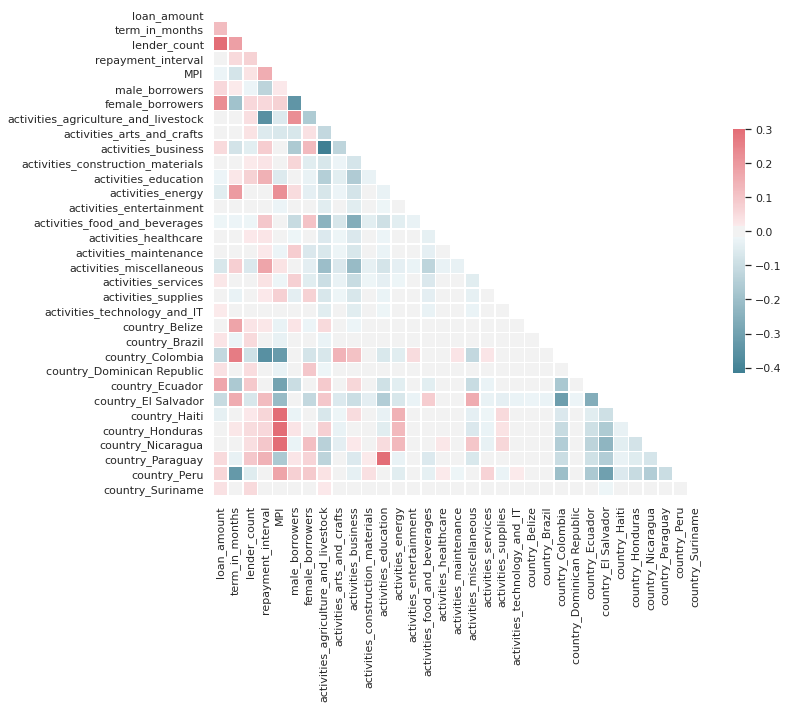

In [0]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 5.8 Hyperparameter tuning

### 5.8.1 Creating the dictionary of the models

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'hgbc': HistGradientBoostingClassifier(random_state=42),
          'xgbc': XGBClassifier(seed=42),
          'mlpc': MLPClassifier(early_stopping=True, random_state=42)}

### 5.8.2 Creating the dictionary of the pipelines

In [0]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

### 5.8.3 Getting the predefined split cross-validator

In [0]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### 5.8.4 Creating the dictionary of the parameter grids

In [0]:
param_grids = {}

#### 5.8.4.1 The parameter grid for logistic regression

In [0]:
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

In [0]:
tol_grids

[1e-06, 1e-05, 0.0001, 0.001, 0.01]

#### 5.8.4.2 The parameter grid for decision tree

In [0]:
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 11)

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

#### 5.8.4.3 The parameter grid for random forest

In [0]:
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Implement me
# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

#### 5.8.4.4 The parameter grid for histogram-based gradient boosting

In [0]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Implement me
# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

#### 5.8.4.5 The parameter grid for xgboost

In [0]:
# The grids for eta
eta_grids = [10 ** i for i in range(-4, 1)]

# The grids for gamma
gamma_grids = [0, 10, 100]

# The grids for lambda
lambda_grids = [10 ** i for i in range(-4, 5)]

# Implement me
# Update param_grids
param_grids['xgbc'] = [{'model__eta': eta_grids,
                        'model__gamma': gamma_grids,
                        'model__lambda': lambda_grids}]

#### 5.8.4.6 The parameter grid for multi-layer perceptron classifier

In [0]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-4, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-4, -1)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

### 5.8.5 Creating the directory for the cv results.

In [0]:
import os

# Make directory
directory = os.path.dirname('./cv_classification_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### 5.8.6 Hyperparameter tuning 

In [0]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='./cv_classification_results/' + acronym + '.csv', index=False)

### 5.8.7 Model Selection

In [0]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.873133,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(l2_regularizat...
1,0.852161,"{'model__eta': 0.0001, 'model__gamma': 0, 'mod...","(XGBClassifier(base_score=0.5, booster='gbtree..."
2,0.849966,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
3,0.845943,"{'model__alpha': 0.001, 'model__learning_rate_...","(MLPClassifier(activation='relu', alpha=0.001,..."
4,0.840456,"{'model__max_depth': 10, 'model__min_samples_l...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
5,0.706334,"{'model__C': 10, 'model__tol': 1e-06}","(LogisticRegression(C=10, class_weight='balanc..."


In [0]:
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

## 5.9 Confusion Matrix

In [0]:
# Create the directory for figure_classification
import os

# Make directory
directory = os.path.dirname('./figure_classification/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
# Select the best model
classifier = best_estimator_gs

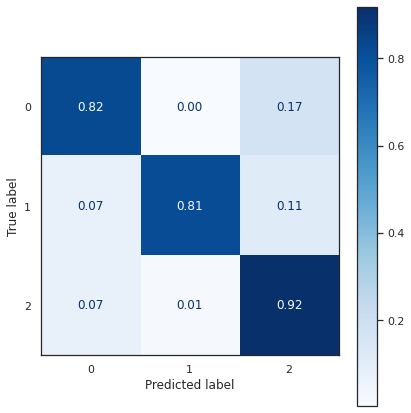

In [0]:
from sklearn.metrics import plot_confusion_matrix

# Create a figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Plot the confusion matrix
plot_confusion_matrix(classifier,
                      X_valid,
                      y_valid,
                      normalize='true',
                      display_labels=np.unique(y_valid),
                      values_format='.2f',
                      cmap=plt.cm.Blues,
                      ax=ax)

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure_classification/confusion_matrix.pdf')
plt.show()

## 5.10 Plot the feature importance

In [0]:
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_param_estimator_gs[2]

# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print df_fi_rfc
df_fi_rfc[:10]

,Features,Importance
0,term_in_months,0.340103
1,activities_agriculture_and_livestock,0.111193
2,country_Colombia,0.10305
3,MPI,0.08302
4,loan_amount,0.0752739
5,lender_count,0.0635634
6,female_borrowers,0.0317258
7,country_El Salvador,0.0248553
8,country_Ecuador,0.0242868
9,country_Peru,0.0216936


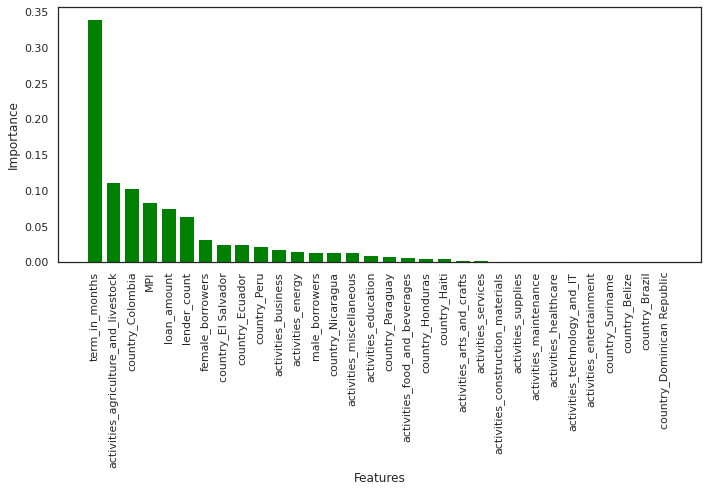

In [0]:
# Create a figure
fig = plt.figure(figsize=(10, 7))

# The bar plot of feature importance
plt.bar(df_fi_rfc['Features'], df_fi_rfc['Importance'], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.savefig('./figure_classification/feature_importance_rfc.pdf')
plt.show()

## 5.11 Generating the submission file

In [0]:
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[0]

In [0]:
# Get the prediction on the testing data using best_model
y_test_pred = best_estimator_gs.predict(X_test)

# Transform y_test_pred back to the original class
y_test_pred = le.inverse_transform(y_test_pred)

# Get the submission dataframe
df_submit = pd.DataFrame(np.hstack((np.arange(1, y_test_pred.shape[0] + 1).reshape(-1, 1), y_test_pred.reshape(-1, 1))),
                         columns=['ImageId', 'Label'])                                                                                      

# Generate the submission file
df_submit.to_csv('submission_classification.csv', index=False)

# 6) Conclusions

- Interestingly, there is a strong positive correlation between the number of female borrowers and loan amount, as the correlation plot suggests.
- Term in months is the feature with the most predictive power for determining the interval payment in Latin America. 
- Loans granted for agriculture and livestock activities is also an important feature with high predictive power. As depicted in the correlation matrix, there is a strong positive correlation between financed agriculture activies and male borrowers.
- Histogram Gradient Boosting Classifier (with a learning rate of 0.1) proved to be the model with the highest score; followed by Xgboost and Random Forest.
- The Multidimensional Poverty Index of a country is the fourth feature with the most information gain.